In [5]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from numpy import linspace, zeros
from scipy.integrate import odeint
from scipy.fftpack import diff as psdiff
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable


%matplotlib inline
plt.style.use('bmh')

EJERCICIO 1

u.spahe :  (201,)
x.shape :  (201,)
t.shape :  (5001,)
 
CPU time :  -3.536155596
dt = T/len( user_data[ 'u' ] ) :  4.999000199960008e-05
 


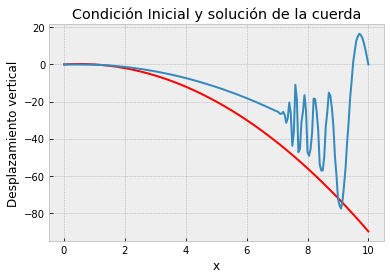

In [6]:
def Solver( b, I, V, f, c, L, Nx, C, T, user_action = None ):

  # PARA RESOLVER EL u_tt = c^2 * u_xx + f
  # SOBRE (0, L)x(0, T)

  x = np.linspace( 0, L, Nx + 1 )     # MALLA X

  dx = x[ 1 ] - x[ 0 ]
  dt = C*dx/c
  Nt = int( round( T/dt ) )

  t = np.linspace( 0, Nt*dt, Nt + 1 ) # MALLA T

  k = dt

  C1 = ( 1/( 1 + ( b*k/2 ) ) )
  C2 = C**2
  C3 = b*k/2
  C4 = ( 1/( 1 + C1*C3 + C1 ) )
  
  if f is None or f == 0:
    f = lambda x, t: 0

  if V is None or V == 0:
    V = lambda x: 0

  u0 = zeros( Nx + 1 ) # SOLUCION AL NUEVO TIEMPO
  u1 = zeros( Nx + 1 )
  u2 = zeros( Nx + 1 ) 

  import time;
  # MEDIREMOS EL TIEMPO DE USO DE CPU
  t0 = time.process_time()

  for i in range( 0, Nx + 1 ): 
    u1[ i ] = I( x[ i ] )     

  if user_action is not None:
    user_action( u1, x, t, 0 )

 
  n = 0

  for i in range( 1, Nx ): 
    u0[ i ] = 2*C1*C4*( u1[ i ] ) + dt*V( x[ i ] ) + \
    C4*( C1*C2*( u1[ i - 1 ] - 2*u1[ i ] + u1[ i + 1 ] ) ) + \
    dt**2*f( x[ i ], t[ n ] )

  u0[ 0 ] = 0; u0[ Nx ] = 0  

  if user_action is not None:
    user_action( u0, x, t, 1 )

  # REDIFINIMOS LA VARIABLE PARA REUTILIZAR
  
  u2[ : ], u1[ : ] = u1, u0 

  for i in range( 1, Nt ): 
    for i in range( 1, Nx ):
      u0[ i ] = -C1*u2[ i ] + 2*C*u1[ i ] + \
      ( C1 )*( C3*u2[ i ] + C2*( u1[ i - 1 ] - 2*u1[ i ] + u1[ i + 1 ] ) ) + \
      dt**2*f( x[ i ], t[ n ] )

    # DEFINICION DE LAS CONDICIONES DE LAS FRONTERAS

    u0[ 0 ] = 0; u0[ Nx ] = 0

    if user_action is not None:
      if user_action( u0, x, t, n + 1 ):
        break



    u2[ : ], u1[ : ] = u1, u0


  cpu_time = t0 - time.process_time()
  return u0, x, t, cpu_time

###############################################################################

def user_action( u0, x, t, n ):
 
  global user_data

  if 'x' not in user_data:
    user_data[ 'x' ] = x
  if 'u' not in user_data:
    user_data[ 'u' ] = [ ( n, u0 ) ]
  else:
    user_data[ 'u' ].append( ( t[ n ], u0.copy() ) )


# Solver( I, V, f, c, L, Nx, C, T, user_action = None ) 

# b  = COEFIENCIENTE DE AMORTIGUAMIENTO
# I  = CONDICION INICIAL
# V  = VELOCIDAD INICIAL
# f  = FUNCION DE FORZAMIENTO
# c  = VELOCIDAD DE PROPAGACION
# L  = LONGITUD DE LA CUERDA
# Nx = NUMERO DE PUNTOS EN X
# C  = CONSTANTE
# T  = TIEMPO FINAL DE INTEGRACION


user_data = {}
u, x, t, cpu_time = Solver( 0.5, lambda x: x*( 1 - x ), None,
                           None, 100, 10, 200, 0.1, 0.25,
                           user_action = user_action ) 

print( "u.spahe : ", u.shape )
print( "x.shape : ", x.shape )
print( "t.shape : ", t.shape )
print( " " )
print( "CPU time : ", cpu_time )
print( "dt = T/len( user_data[ 'u' ] ) : ", 0.25/len( user_data[ 'u' ] ) )
print( " " )

I = x*(1-x)

plt.xlabel( "x" )
plt.ylabel( "Desplazamiento vertical" )
plt.title( "Condición Inicial y solución de la cuerda" )
plt.plot( x, I, color = "red" )
plt.plot( x, u )

EJERCICIO 2

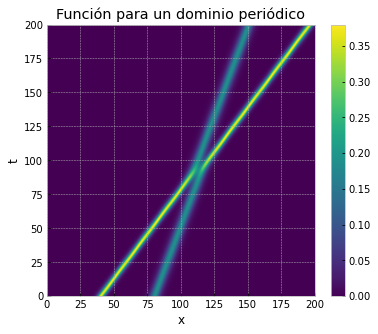

In [7]:
# SOLUCION DE LA ECUACION EN UN DOMINIO PERIODICO


def kdv_exact(x, c):
    u = 0.5*c*np.cosh(0.5*np.sqrt(c)*x)**(-2)
    return u

def kdv(u, t, L):
    ux = psdiff(u, period=L)
    uxxx = psdiff(u, period=L, order=3)
    dudt = -6*u*ux - uxxx
    return dudt

def kdv_solution(u0, t, L):
    sol = odeint(kdv, u0, t, args=(L,), mxstep=5000)
    return sol

if __name__ == "__main__":
    # DEFINIMOS EL TAMAÑO DEL DOMINIO
    L = 200.0    
    Nx = 256

    dx = L / (Nx - 1.0) # dx < 0.8
    x = np.linspace(0, (1-1.0/Nx)*L, Nx) # L < N

    # DEFINIMOS LAS CONDICIONES INICILAES
    x01 = 0.2*L
    x02 = 0.4*L
    c1= 0.76
    c2= 0.38
    u0 = kdv_exact(x-x01, c1) + kdv_exact(x-x02, c2) 
    
    # DEFINIMOS EL DOMINIO EN EL TIEMPO
    T = 200
    Nt = 501 # TIEMPO FINAL DE INTEGRACIÓN
    t = np.linspace(0, T, Nt)
    sol = kdv_solution(u0, t, L)
    import matplotlib.pyplot as plt

    plt.figure(figsize=(6,5))
    plt.imshow(sol[::-1, :], extent=[0,L,0,T])
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('t')
    plt.axis('auto')
    plt.title('Función para un dominio periódico')
    plt.show()

EJERCICIO 3

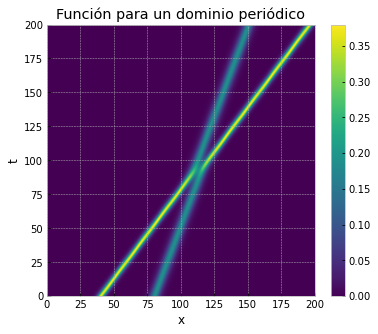

In [8]:
# SOLUCION DE LA ECUACION EN UN DOMINIO PERIODICO


def kdv_exact(x, c):
    u = 0.5*c*np.cosh(0.5*np.sqrt(c)*x)**(-2)
    return u

def kdv(u, t, L):
    ux = psdiff(u, period=L)
    uxxx = psdiff(u, period=L, order=3)
    dudt = -6*u*ux - uxxx
    return dudt

def kdv_solution(u0, t, L):
    sol = odeint(kdv, u0, t, args=(L,), mxstep=5000)
    return sol

if __name__ == "__main__":
    # DEFINIMOS EL TAMAÑO DEL DOMINIO
    L = 200.0    
    Nx = 256

    dx = L / (Nx - 1.0) # dx < 0.8
    x = np.linspace(0, (1-1.0/Nx)*L, Nx) # L < N

    # DEFINIMOS LAS CONDICIONES INICILAES
    x01 = 0.2*L
    x02 = 0.4*L
    c1= 0.76
    c2= 0.38
    u0 = kdv_exact(x-x01, c1) + kdv_exact(x-x02, c2) 
    
    # DEFINIMOS EL DOMINIO EN EL TIEMPO
    T = 200
    Nt = 501 # TIEMPO FINAL DE INTEGRACIÓN
    t = np.linspace(0, T, Nt)
    sol = kdv_solution(u0, t, L)
    import matplotlib.pyplot as plt

    plt.figure(figsize=(6,5))
    plt.imshow(sol[::-1, :], extent=[0,L,0,T])
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('t')
    plt.axis('auto')
    plt.title('Función para un dominio periódico')
    plt.show()

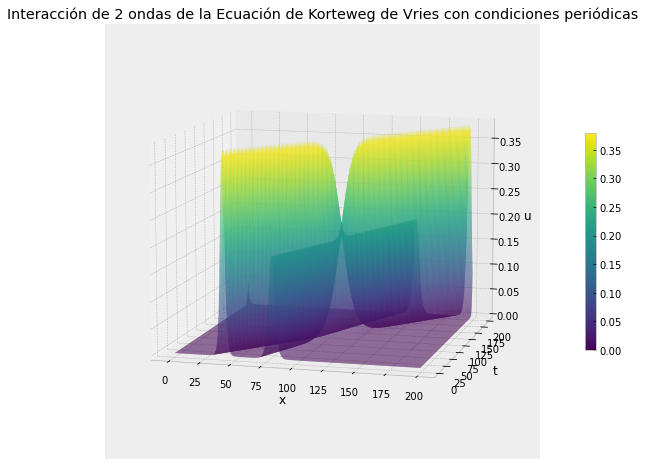

In [9]:
# GRAFICA TIPO 3D
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='3d')

SX, ST = np.meshgrid(x, t)
ax.plot_surface(SX, ST, sol, cmap='viridis', rstride=1, cstride=1, alpha=0.75)

# GRAFICA DE VALORES
m = cm.ScalarMappable(cmap='viridis')
m.set_array(sol)
plt.colorbar(m,shrink=0.5)

ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
ax.view_init(elev=10, azim=-75)
ax.set_title('Interacción de 2 ondas de la Ecuación de Korteweg de Vries con condiciones periódicas')
plt.show()

EJERCICIO 4

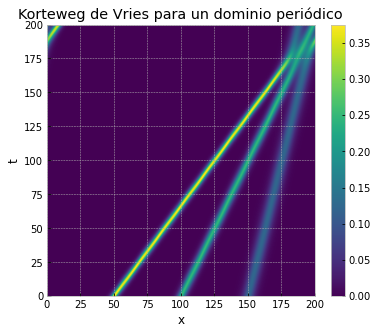

In [10]:
def kdv_exact(x, c):
    u = 0.5*c*np.cosh(0.5*np.sqrt(c)*x)**(-2)
    return u

def kdv(u, t, L):
    ux = psdiff(u, period=L)
    uxxx = psdiff(u, period=L, order=3)
    dudt = -6*u*ux - uxxx
    return dudt

def kdv_solution(u0, t, L):
    sol = odeint(kdv, u0, t, args=(L,), mxstep=5000)
    return sol

if __name__ == "__main__":
    # DEFINIMOS EL TAMAÑO DEL DOMINIO
    L = 200.0
    Nx = 256

    dx = L / (Nx - 1.0) # dx < 0.8
    x = np.linspace(0, (1-1.0/Nx)*L, Nx) # L < N

    # DEFINIMOS LAS CONDICIONES INICIALES
    x01 = 0.25*L
    x02 = 0.5*L
    x03 = 0.75*L
    c1= 0.75
    c2= 0.5
    c3= 0.25
    u0 = kdv_exact(x-x01, c1) + kdv_exact(x-x02, c2) + kdv_exact(x-x03,c3)
    
    # DEFINIMOS EL TAMAÑO DEL DOMINIO EN EL TIEMPO
    T = 200
    Nt = 501 #TIEMPO FINAL DE INTEGRACIÓN
    t = np.linspace(0, T, Nt)

    
    sol = kdv_solution(u0, t, L)
    import matplotlib.pyplot as plt

    plt.figure(figsize=(6,5))
    plt.imshow(sol[::-1, :], extent=[0,L,0,T])
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('t')
    plt.axis('auto')
    plt.title('Korteweg de Vries para un dominio periódico')
    plt.show()

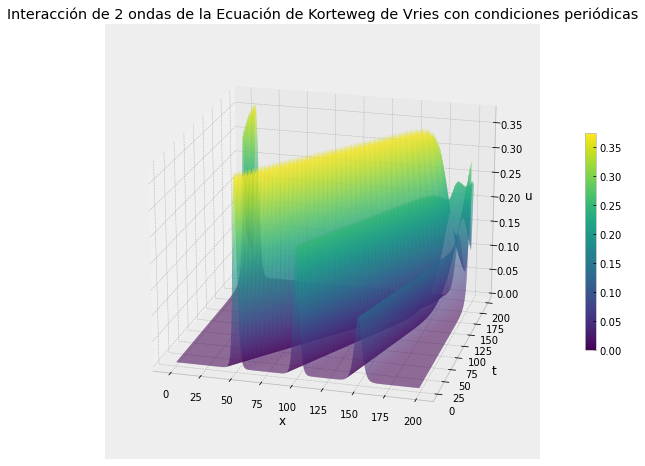

In [11]:
# GRAFICA TIPO 3D

fig = plt.figure( figsize = ( 16, 8 ) )
ax = fig.add_subplot( 111, projection = "3d" )

SX, ST = np.meshgrid( x, t )


ax.plot_surface( SX, ST, sol, cmap = "viridis", 
                rstride = 1, cstride = 1, alpha = 0.75 )

# GRAFICA EN UN TABLA DE VALORES

m = cm.ScalarMappable( cmap = "viridis" )
m.set_array( sol )
plt.colorbar( m, shrink = 0.5 ) 

ax.set_xlabel( "x" )
ax.set_ylabel( "t" )
ax.set_zlabel( "u" )
ax.view_init( elev = 20, azim = -75 )
ax.set_title( "Interacción de 2 ondas de la Ecuación de Korteweg de Vries con condiciones periódicas" )

plt.show()

EJERCICIO 5

N: 200
D: 0.25
Mx: 50
My 50
dx,dy; 0.04 0.04
nsteps: 200


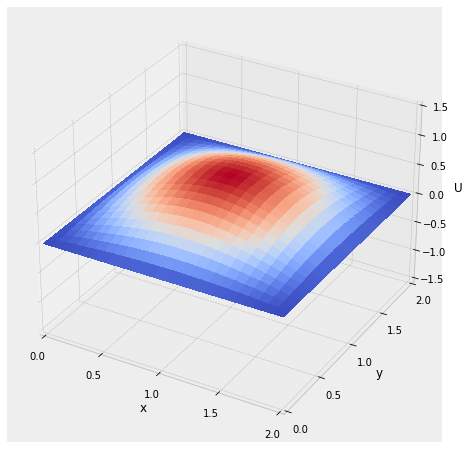

paso: 10.0 t= 0.285


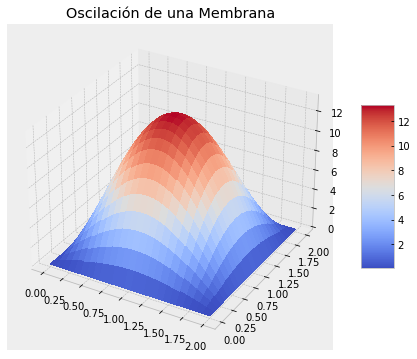

paso: 20.0 t= 0.585


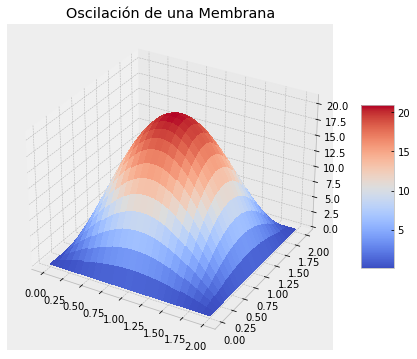

paso: 30.0 t= 0.885


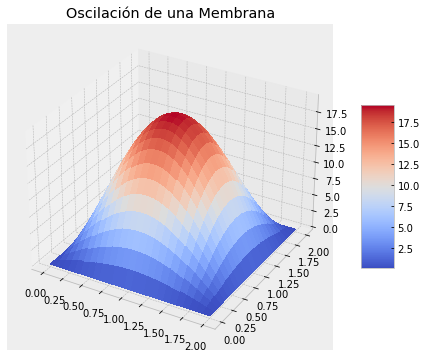

paso: 40.0 t= 1.185


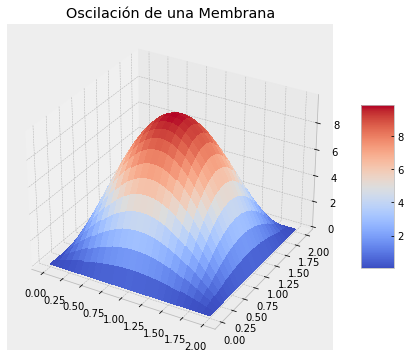

paso: 50.0 t= 1.4849999999999999


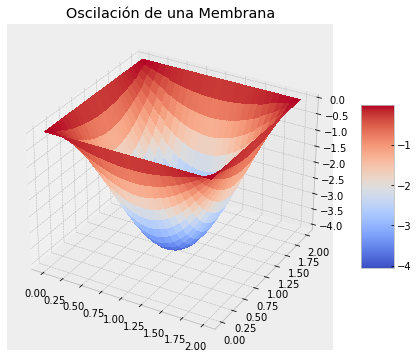

paso: 60.0 t= 1.785


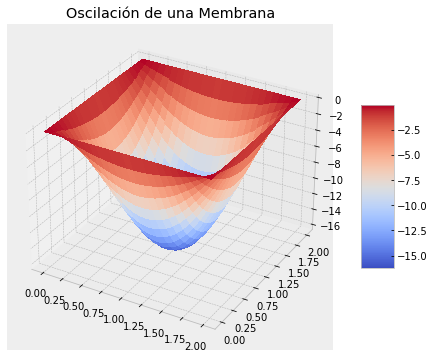

paso: 70.0 t= 2.085


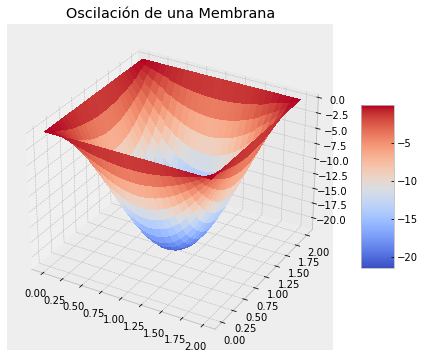

paso: 80.0 t= 2.385


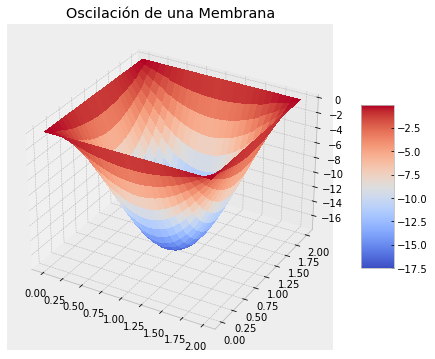

paso: 90.0 t= 2.685


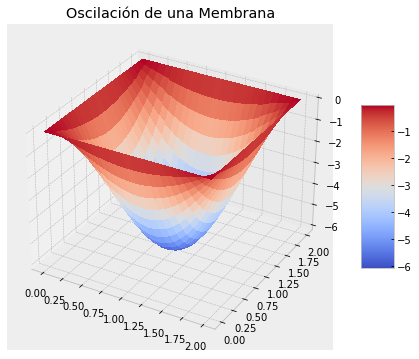

paso: 100.0 t= 2.985


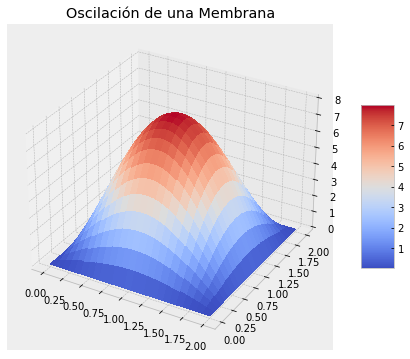

In [12]:
#Solución de la Ecuación de Onda en 2D: Utt = (Uxx+Uyy)
# Método de Diferencias Finitas 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# Se define la Clase general que incluye todas las funciones
class WaveEquationFD:
    
    def __init__(self, N, D, Mx, My):
        self.N = N
        print('N:',N)
        self.D = D
        print('D:',D)
        self.Mx = Mx
        print('Mx:',Mx)
        self.My = My
        print('My',My)
        self.tend = 6
        self.xmin = 0
        self.xmax = 2
        self.ymin = 0
        self.ymax = 2
        self.initialization()
        self.eqnApprox()
           
    def initialization(self):
        self.dx = (self.xmax - self.xmin)/self.Mx
        self.dy = (self.ymax - self.ymin)/self.My
        print('dx,dy;',self.dx,self.dy)
        
        self.x = np.arange(self.xmin, self.xmax+self.dx, self.dx)
        self.y = np.arange(self.ymin, self.ymax+self.dy, self.dy)
        
        #----- Initial condition -----#
        self.u0 = lambda r, s: np.sin(np.pi*r/2)*np.sin(np.pi*s/2)
        
        #----- Initial velocity -----#
        self.v0 = lambda a, b: 0

         #----- Boundary conditions -----#
        self.bxyt = lambda left, right, time: 0
        
        self.dt = (self.tend - 0)/self.N
        self.t = np.arange(0, self.tend+self.dt/2, self.dt)
        
        # Assertion for the condition of r < 1, for stability
        r = 4*self.D*self.dt**2/(self.dx**2+self.dy**2);
        assert r < 1, "r is bigger than 1!"

            
    def eqnApprox(self):
        #----- Approximation equation properties -----#
        self.rx = self.D*self.dt**2/self.dx**2
        self.ry = self.D*self.dt**2/self.dy**2
        self.rxy1 = 1 - self.rx - self.ry 
        self.rxy2 = self.rxy1*2

        #----- Initialization matrix u for solution -----#
        self.u = np.zeros((self.Mx+1, self.My+1))
        self.ut = np.zeros((self.Mx+1, self.My+1))
        self.u_1 = self.u.copy()
        
        #----- Fills initial condition and initial velocity -----#
        for j in range(1, self.Mx):
            for i in range(1, self.My):
                self.u[i,j] = self.u0(self.x[i], self.y[j])
                self.ut[i,j] = self.v0(self.x[i], self.y[j])
        
    
    def solve_and_animate(self):
        
        u_2 = np.zeros((self.Mx+1, self.My+1))
        
        xx, yy = np.meshgrid(self.x, self.y)
         
        fig = plt.figure(figsize=(12,8))        
        ax = fig.add_subplot(111, projection='3d')
        #ax = plt.axes(projection ='3d')
        
        wframe = None
        
        k = 0
        nsteps = self.N
        print('nsteps:',nsteps)

        while k < nsteps:
            if wframe:
                ax.collections.remove(wframe)
                
            self.t = k*self.dt
            
            #----- Fills in boundary condition along y-axis (vertical, columns 0 and Mx) -----#
            for i in range(self.My+1):
                self.u[i, 0] = self.bxyt(self.x[0], self.y[i], self.t)
                self.u[i, self.Mx] = self.bxyt(self.x[self.Mx], self.y[i], self.t)
                
            for j in range(self.Mx+1):
                self.u[0, j] = self.bxyt(self.x[j], self.y[0], self.t)
                self.u[self.My, j] = self.bxyt(self.x[j], self.y[self.My], self.t)
                
            if k == 0:
                for j in range(1, self.My):
                    for i in range(1, self.Mx):
                        self.u[i,j] = 0.5*(self.rx*(self.u_1[i-1,j] + self.u_1[i+1,j])) \
                                + 0.5*(self.ry*(self.u_1[i,j-1] + self.u_1[i,j+1])) \
                                + self.rxy1*self.u[i,j] + self.dt*self.ut[i,j]
            else:
                for j in range(1, self.My):
                    for i in range(1, self.Mx):
                        self.u[i,j] = self.rx*(self.u_1[i-1,j] + self.u_1[i+1,j]) \
                            + self.ry*(self.u_1[i,j-1] + self.u_1[i,j+1]) \
                            + self.rxy2*self.u[i,j] - u_2[i,j]
                            
            u_2 = self.u_1.copy()
            self.u_1 = self.u.copy()

            wframe = ax.plot_surface(xx, yy, self.u, cmap=cm.coolwarm, linewidth=2, 
                    antialiased=False)
            
            ax.set_xlim3d(0, 2.0)
            ax.set_ylim3d(0, 2.0)
            ax.set_zlim3d(-1.5, 1.5)
            
            ax.set_xticks([0, 0.5, 1.0, 1.5, 2.0])
            ax.set_yticks([0, 0.5, 1.0, 1.5, 2.0])
            
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_zlabel("U")

            plt.pause(0.05)
            k += 0.5
            
            # Sección añadida para hacer gráficas cada 15 pasos 
            if (k < 101 and k%10 == 0):
                print('paso:',k, 't=', self.t)
                # Creating figure
                fig2 = plt.figure(figsize =(10, 6))
                ax2 = plt.axes(projection ='3d')
                # Creating color map
                my_cmap = plt.get_cmap('coolwarm')
                # Creating plot
                surf = ax2.plot_surface(xx, yy, self.u, cmap=cm.coolwarm, linewidth=2, 
                    antialiased=False)
                fig.colorbar(surf, ax = ax2,
                    shrink = 0.5, aspect = 5)
                ax2.set_title('Oscilación de una Membrana')
                # show plot
                plt.show()

# Se definen los parámetros con los que se va a ejecutar el código     
# N pasos de integración, parámetro de estabilidad < 0.5, Num.Puntos x, Núm.Puntos y

def main():
    simulator = WaveEquationFD(200, 0.25, 50, 50)
    simulator.solve_and_animate() # No funcionó en Google Colab
    plt.show()
    
if __name__ == "__main__":
    main()

EJERCICIO 6

N :  200
D :  0.25
Mx :  50
My :  50
dx,dy ;  0.04 0.04
nsteps :  200


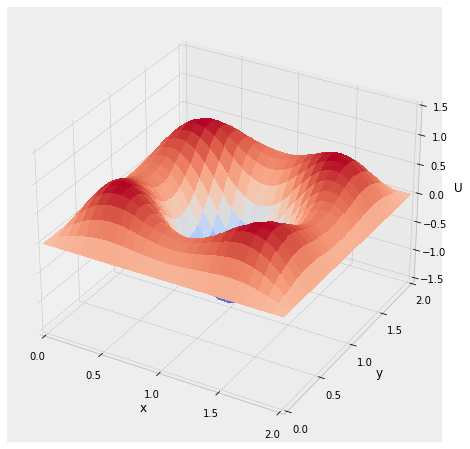

paso : 10.0 t = 0.285


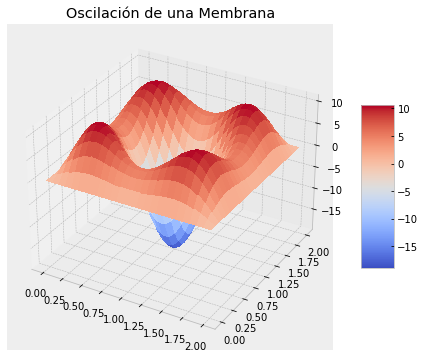

paso : 20.0 t = 0.585


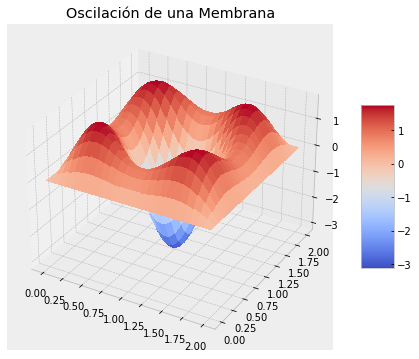

paso : 30.0 t = 0.885


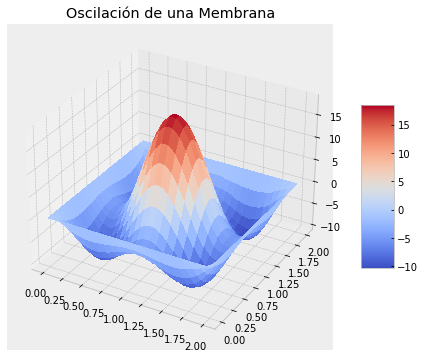

paso : 40.0 t = 1.185


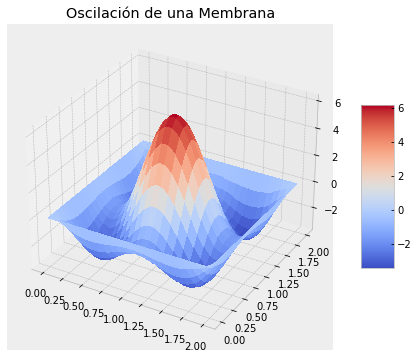

paso : 50.0 t = 1.4849999999999999


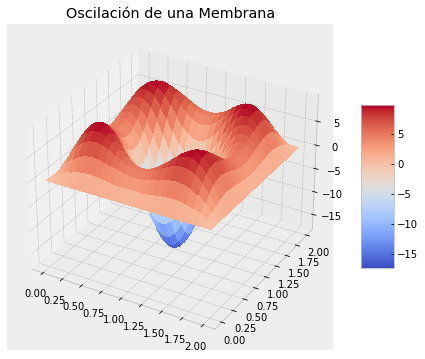

paso : 60.0 t = 1.785


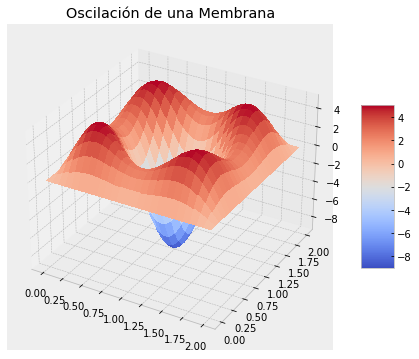

paso : 70.0 t = 2.085


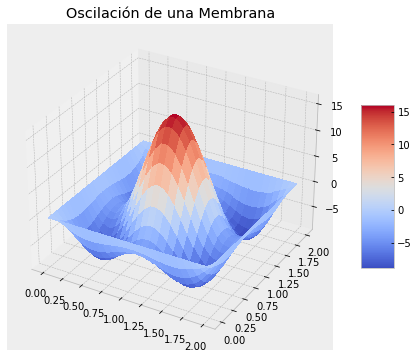

paso : 80.0 t = 2.385


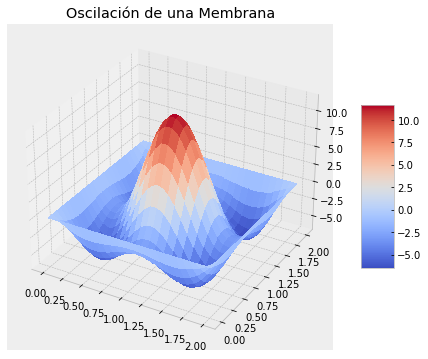

paso : 90.0 t = 2.685


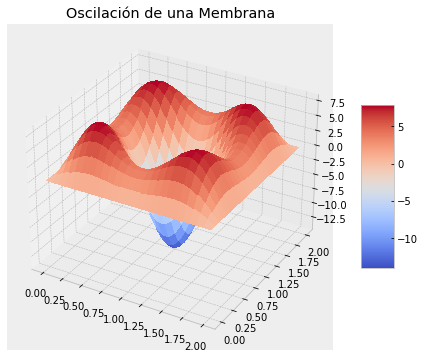

paso : 100.0 t = 2.985


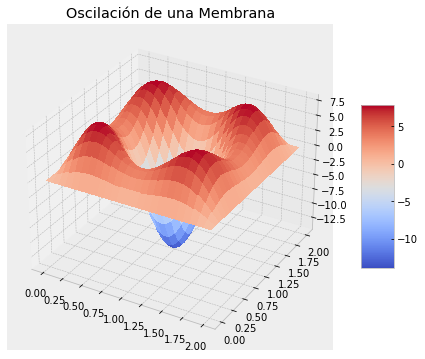

In [13]:
# SOLUCIÓN DEL PROBLEMA 
class WaveEquationFD:

  def __init__( self, N, D, Mx, My ):

    self.N = N
    print( "N : ", N )

    self.D = D
    print( "D : ", D )

    self.Mx = Mx
    print( "Mx : ", Mx )

    self.My = My
    print( "My : ", My )

    self.tend = 6
    self.xmin = 0
    self.xmax = 2
    self.ymin = 0
    self.ymax = 2
    self.initialization()
    self.eqnApprox()


  def initialization( self ):

    self.dx = ( self.xmax - self.xmin )/self.Mx
    self.dy = ( self.ymax - self.ymin )/self.My
    print( "dx,dy ; ", self.dx, self.dy )

    self.x = np.arange( self.xmin, self.xmax + self.dx, self.dx )
    self.y = np.arange( self.ymin, self.ymax + self.dy, self.dy )

    #---- Condición Inicial ----#
    self.u0 = lambda r, s: np.sin( 3*np.pi*r/2 )*np.sin( np.pi*s/2 ) \
    + np.sin( np.pi*r/2 )*np.sin( 3*np.pi*s/2 )

    #---- Velocidad Inicial ----#
    self.v0 = lambda a, b: 0

    #---- Condiciones de Frontera ----#
    self.bxyt = lambda left, right, time: 0

    self.dt = ( self.tend - 0 )/self.N
    self.t = np.arange( 0, self.tend + self.dt/2, self.dt )

    # Afirmación por la condición de r < 1, por estabilidad
    r = 4*self.D*self.dt**2/( self.dx**2 + self.dy**2 );
    assert r < 1, "r is bigger than 1!"


  def eqnApprox( self ):

    #---- Propiedades de la ecuación de aproximación ----#

    self.rx = self.D*self.dt**2/self.dx**2
    self.ry = self.D*self.dt**2/self.dy**2
    self.rxy1 = 1 - self.rx - self.ry 
    self.rxy2 = self.rxy1*2

    #---- Matriz de inicialización u para solución ----#

    self.u = np.zeros( ( self.Mx+1, self.My + 1 ) )
    self.ut = np.zeros( ( self.Mx+1, self.My + 1 ) )
    self.u_1 = self.u.copy()

    #---- Llena la condición inicial y la velocidad inicial ----#

    for j in range( 1, self.Mx ):
        for i in range( 1, self.My ):
            self.u[ i, j ] = self.u0( self.x[ i ], self.y[ j ] )
            self.ut[ i, j ] = self.v0( self.x[ i ], self.y[ j ] )


  def solve_and_animate( self ):
        
    u_2 = np.zeros( ( self.Mx + 1, self.My + 1 ) )
        
    xx, yy = np.meshgrid( self.x, self.y )
         
    fig = plt.figure( figsize = ( 12, 8 ) )        
    ax = fig.add_subplot( 111, projection = "3d" ) 
    #---- ax = plt.axes( projection = "3d" ) ----#
        
    wframe = None

    k = 0
    nsteps = self.N
    print( "nsteps : ", nsteps )
        
    while k < nsteps:
      if wframe:
        ax.collections.remove( wframe )          
      self.t = k*self.dt

      #---- Rellena la condición de frontera a lo largo ----#
      #---- del eje y (vertical, columnas 0 y Mx) ----#

      for i in range( self.My + 1 ):
        self.u[ i, 0 ] = self.bxyt( self.x[ 0 ], self.y[ i ], self.t )
        self.u[ i, self.Mx ] = self.bxyt( self.x[ self.Mx ], self.y[ i ], self.t )
                
      for j in range( self.Mx + 1 ):
        self.u[ 0, j ] = self.bxyt( self.x[ j ], self.y[ 0 ], self.t )
        self.u[ self.My, j ] = self.bxyt( self.x[ j ], self.y[ self.My] , self.t )

      if k == 0:
        for j in range( 1, self.My ):
          for i in range( 1, self.Mx ):
            self.u[ i, j ] = 0.5*( self.rx*( self.u_1[ i - 1, j ] + self.u_1[ i + 1, j ] ) ) \
                + 0.5*( self.ry*( self.u_1[ i, j - 1 ] + self.u_1[ i, j + 1 ] ) ) \
                + self.rxy1*self.u[ i, j ] + self.dt*self.ut[ i, j ]
      
      else:
        for j in range( 1, self.My ):
          for i in range( 1, self.Mx ):
            self.u[ i, j ] = self.rx*( self.u_1[ i - 1, j ] + self.u_1[ i + 1, j ] ) \
              + self.ry*( self.u_1[ i, j - 1 ] + self.u_1[ i, j + 1 ] ) \
              + self.rxy2*self.u[ i, j ] - u_2[ i, j ]
      
      u_2 = self.u_1.copy()
      self.u_1 = self.u.copy()

      wframe = ax.plot_surface( xx, yy, self.u, cmap = cm.coolwarm, 
                               linewidth = 2, antialiased = False)
      
      ax.set_xlim3d( 0, 2.0 )
      ax.set_ylim3d( 0, 2.0 )
      ax.set_zlim3d( -1.5, 1.5 )
            
      ax.set_xticks( [ 0, 0.5, 1.0, 1.5, 2.0 ] )
      ax.set_yticks( [ 0, 0.5, 1.0, 1.5, 2.0 ] )
            
      ax.set_xlabel( "x" )
      ax.set_ylabel( "y" )
      ax.set_zlabel( "U" )
            
      plt.pause( 0.05 )
      k += 0.5

      #---- Sección añadida para hacer gráficas cada 15 pasos ----#
      if ( k < 101 and k%10 == 0 ):
        print( "paso :", k, "t =", self.t )

        #---- Creating figure ----#
        fig2 = plt.figure( figsize = ( 10, 6 ) )
        ax2 = plt.axes( projection = "3d" )

        #---- Creating color map ----#
        my_cmap = plt.get_cmap( "coolwarm" )

        #---- Creating plot ----#
        surf = ax2.plot_surface( xx, yy, self.u, 
          cmap = cm.coolwarm, linewidth = 2, antialiased = False )
        fig.colorbar( surf, ax = ax2,
          shrink = 0.5, aspect = 5)
        ax2.set_title( "Oscilación de una Membrana" )
          
        plt.show()

def main():
  simulator = WaveEquationFD( 200, 0.25, 50, 50 )
  simulator.solve_and_animate()
  plt.show()
    
if __name__ == "__main__":
  main()